# 标准自动编码器
由 Hinton 提出的标准自动编码机（标准自编码器）只有一个隐藏层，隐藏层中神经元的数量少于输入（和输出）层中神经元的数量，这会压缩网络中的信息，因此可以将隐藏层看作是一个压缩层，限定保留的信息。

自动编码机的学习包括在隐藏层上对输入信号进行压缩表示，然后在输出层尽可能地复现原始输入：  
![标准自编码器](2-1Z11115591U54.png)

## 实例：利用 MNIST 数据训练自动编码器，并使用它来重构测试图像

1. 导入模块

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

2. 从 TensorFlow 中获取 MNIST 数据  
`注意：自动编码机是通过无监督学习进行训练，因此没有使用标签来训练网络。`

In [2]:
mnist = input_data.read_data_sets('MNIST_data')
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


3. 声明 AutoEncoder 类  
`使用 init 方法初始化自动编码机的权重、偏置和占位符，也可以在 init 方法中构建全部的计算图。  
 还需要定义编码器、解码器，set_session（会话建立）和 fit 方法。  
 此处构建的自动编码机使用简单的均方误差作为损失函数  
 使用 AdamOptimizer 进行优化
 `

In [3]:
class AutoEncoder:
    """标准自动编码器"""
    
    def __init__(self, m, n, eta=0.01):
        """
        m：输入输出层神经元数
        n：隐藏层神经元数
        """
        self._m = m
        self._n = n
        self.learning_rate = eta
        self.session = None
        
        # 构建计算图
        
        # 权重与偏置
        self._W1 = tf.Variable(tf.random_normal(shape=(self._m, self._n)))
        self._W2 = tf.Variable(tf.random_normal(shape=(self._n, self._m)))
        self._b1 = tf.Variable(np.zeros(self._n).astype(np.float32))    # 隐藏层偏置
        self._b2 = tf.Variable(np.zeros(self._m).astype(np.float32))    # 输出层偏置
        
        # 输入层占位符
        self._X = tf.placeholder('float', shape=[None, self._m])
        
        # 编码器
        self.y = self.encoder(self._X)
        
        # 解码器
        self.r = self.decoder(self.y)
        
        # 解码误差
        error = self._X - self.r
        
        # 损失函数
        self._loss = tf.reduce_mean(tf.pow(error, 2))   # MSE
        
        # 优化算法
        self._opt = tf.train.AdamOptimizer(self.learning_rate).minimize(self._loss)
    
    def encoder(self, x):
        """编码器"""
        h = tf.matmul(x, self._W1) + self._b1
        return tf.nn.sigmoid(h)
    
    def decoder(self, x):
        """解码器"""
        h = tf.matmul(x, self._W2) + self._b2
        return tf.nn.sigmoid(h)
    
    def set_session(self, session):
        """开启会话"""
        self.session = session
        
    def reduced_dimension(self, x):
        """降维"""
        h = self.encoder(x)
        return self.session.run(h, feed_dict={self._X: x})
    
    def reconstruct(self, x):
        """重构"""
        h = self.encoder(x)
        r = self.decoder(h)
        return self.session.run(r, feed_dict={self._X: x})
    
    def fit(self, X, epochs=1, batch_size=100):
        """训练"""
        N, D = X.shape
        num_batches = N // batch_size
        obj = []
        for i in range(epochs):
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run(
                    [self._opt, self._loss],
                    feed_dict={self._X: batch}
                )
                if j % 100 == 0 and i % 100:
                    print('training epoch {0} batch {2} cost {1}'.format(i, ob, j))
                obj.append(ob)
        return obj

`为便于使用，此处还定义了两个辅助函数，reduced_dimension 给出编码器网络的输出，reconstruct 给出重构的测试图像的输出。`

4. 训练时将输入数据转换为 float 型，初始化所有变量并运行会话。在计算时，测试自动编码机的重构能力

In [4]:
Xtrain = trX.astype(np.float32)
Xtest = teX.astype(np.float32)
_, m = Xtrain.shape

auto_encoder = AutoEncoder(m, 256)   # 实例化自编码器

# 变量初始化
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    auto_encoder.set_session(sess)
    err = auto_encoder.fit(Xtrain, epochs=10)
    out = auto_encoder.reconstruct(Xtest[:100])

Instructions for updating:
Colocations handled automatically by placer.
training epoch 1 batch 0 cost 0.05110756307840347
training epoch 1 batch 100 cost 0.0439513623714447
training epoch 1 batch 200 cost 0.043250516057014465
training epoch 1 batch 300 cost 0.04521690681576729
training epoch 1 batch 400 cost 0.04120133817195892
training epoch 1 batch 500 cost 0.043769001960754395
training epoch 2 batch 0 cost 0.04310230538249016
training epoch 2 batch 100 cost 0.0376976914703846
training epoch 2 batch 200 cost 0.037839263677597046
training epoch 2 batch 300 cost 0.040796972811222076
training epoch 2 batch 400 cost 0.03818133845925331
training epoch 2 batch 500 cost 0.04142695292830467
training epoch 3 batch 0 cost 0.040615975856781006
training epoch 3 batch 100 cost 0.03574133291840553
training epoch 3 batch 200 cost 0.03625974431633949
training epoch 3 batch 300 cost 0.03895460441708565
training epoch 3 batch 400 cost 0.03667350113391876
training epoch 3 batch 500 cost 0.0396633557975

5. 绘制误差在训练周期中的变化图，验证网络的均方误差在训练时是否得到优化，对于一个好的训练，误差应该随着训练周期的增加而减少

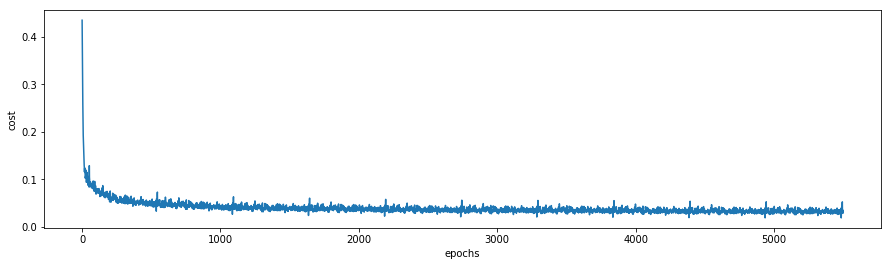

In [5]:
plt.figure(figsize=(15, 4))
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()

`可以看到，随着网络的学习，损失/成本是下降的，当训练周期达到 5000 时，几乎是在一条线上振荡，这意味着进一步增加训练周期将不再有用。如果现在还想要改进模型，应该调整学习率、批量大小和优化器等超参数。`

6. 观察重构的图像，对比原始图像和自动编码机生成的重构图像

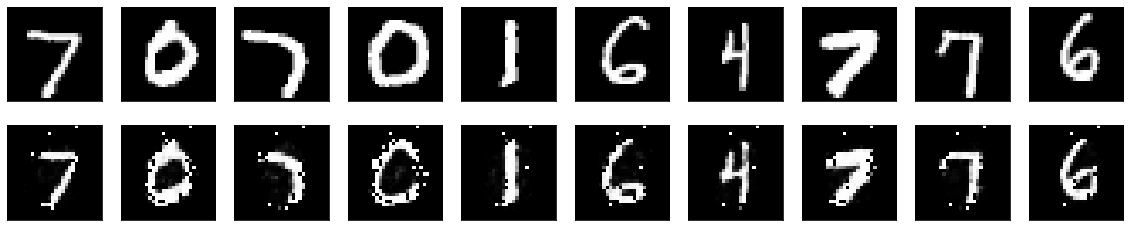

In [6]:
row, col = 2, 10
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20, 4))
for fig, row in zip([Xtest, out], axarr):
    for i, ax in zip(idx, row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)